## Setup

In [1]:
%%capture
%pip install -U bitsandbytes loralib
%pip install -U transformers
%pip install -U peft
%pip install -U accelerate
%pip install -U trl
%pip install datasets==2.16.0


In [2]:
import os 
PROJECT_DIR_PATH = ''
OUTPUT_PATH = os.path.join(PROJECT_DIR_PATH, 'models')

BASELINE_MODEL_NAME = 'OpenPipe/mistral-ft-optimized-1227'
PROJECT_NAME = 'OpenPipe_mistral-ft-optimized-1227'
HUGGING_FACE_REPO_NAME = f'Jayem-11/{PROJECT_NAME}'
HUGGING_FACE_MERGED_REPO_NAME = f'{HUGGING_FACE_REPO_NAME}_merged'

In [3]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_hf = user_secrets.get_secret("hf")
secret_wandb = user_secrets.get_secret("wandb-key")

In [4]:
!huggingface-cli login --token $secret_hf

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [5]:
import wandb
wandb.login(key = secret_wandb)
run = wandb.init(
    project='Fine tuning openpipe mistral 7B', 
    job_type="training", 
    anonymous="allow"
)

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: ronojohnmichael. Use `wandb login --relogin` to force relogin
wandb: wandb version 0.16.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.16.2
wandb: Run data is saved locally in /kaggle/working/wandb/run-20240213_110706-dtkbpdvw
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run glittering-cake-4
wandb: ⭐️ View project at https://wandb.ai/ronojohnmichael/Fine%20tuning%20openpipe%20mistral%207B
wandb: 🚀 View run at https://wandb.ai/ronojohnmichael/Fine%20tuning%20openpipe%20mistral%207B/runs/dtkbpdvw


## Dataset

In [6]:
import pandas as pd
train = pd.read_csv("/kaggle/input/strengthening-malawi/Train.csv")
train  = train[["Question Text", "Question Answer"]]
train = train.values.tolist()

In [7]:
# Get tokenizer.
import transformers
tokenizer = transformers.AutoTokenizer.from_pretrained(BASELINE_MODEL_NAME,
                                                       padding_side='left',
                                                       add_eos_token=True)
tokenizer.pad_token = tokenizer.eos_token

tokenizer_config.json:   0%|          | 0.00/967 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

## Preprocessing

In [8]:
def dialogue_to_chat(dialogue):
    out = [{'role': 'system', 'content': 'You are a friendly Medical chatbot assistant.'}]
    for idx, message in enumerate(dialogue):
        role = 'user' if idx%2==0 else 'assistant'
        out.append({'role': role, 'content': message})
    return out

def chat_to_input(chat):
    return tokenizer.apply_chat_template(chat, tokenize=False)

def process_example(example):
    out = dialogue_to_chat(example)                
    out = chat_to_input(out)                    
    return out


In [9]:
data = []
for i in range(len(train)):
    data.append(process_example(train[i]))
    


No chat template is defined for this tokenizer - using the default template for the LlamaTokenizerFast class. If the default is not appropriate for your model, please set `tokenizer.chat_template` to an appropriate template. See https://huggingface.co/docs/transformers/main/chat_templating for more information.



In [10]:
# Shuffle dataset.
from random import shuffle
shuffle(data)

# Tokenize data.
tokenized_data = list(map(tokenizer, data))

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


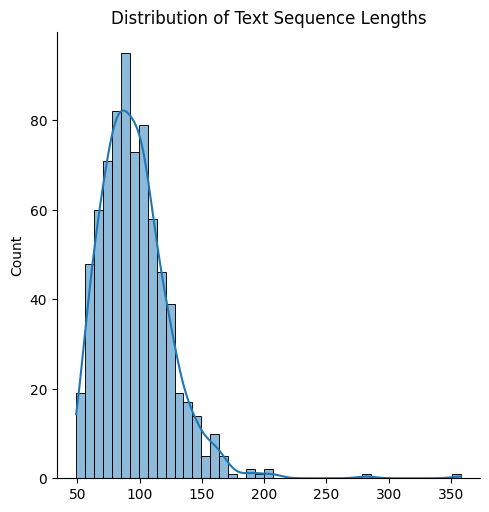

In [11]:
# Plot sequence Lengths.
import seaborn as sns

input_lengths = [len(x['input_ids']) for x in tokenized_data]
sns.displot(input_lengths, kde=True).set(title='Distribution of Text Sequence Lengths')

Sequence lengths after processing and tokenization are mostly smaller than 400 tokens. Let’s maintain a maximum length size of 512 tokens during the finetuning phase.

In [12]:
split_idx = int(.90 * len(data))
train_data, val_data = tokenized_data[:split_idx], tokenized_data[split_idx:]
# train_data = tokenized_data

## Model

In [13]:
import transformers, torch

In [14]:
# Get quantized model.
model = transformers.AutoModelForCausalLM.from_pretrained(BASELINE_MODEL_NAME,
                                                          load_in_4bit=True,    
                                                          device_map='auto')

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/22.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [15]:
# Set PEFT adapter config (16:32).
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training

config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["q_proj", "v_proj"],     # Apply to "q_proj", "v_proj" layers of attention as suggested by paper
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM")

# Stabilize output layer and layernorms & prepare for 4bit training.
model = prepare_model_for_kbit_training(model)

# Set PEFT adapter on model.
model = get_peft_model(model, config)

## Training

In [16]:
# Set Hyperparameters.
MAXLEN=512
BATCH_SIZE=4
GRAD_ACC=4
WARMUP=1
STEPS=1000
OPTIMIZER='paged_adamw_8bit'                   # Use paged optimizer to save memory
LR=1.0e-5                                      # Use value slightly smaller than pretraining lr value & close to LoRA standard

# Setup Callbacks.
# early_stop = transformers.EarlyStoppingCallback(10, 1.15)

# Set training config.
training_config = transformers.TrainingArguments(
                       per_device_train_batch_size=BATCH_SIZE,
                       gradient_accumulation_steps=GRAD_ACC,
                       warmup_steps=WARMUP,
                       max_steps=STEPS,
                       optim=OPTIMIZER,
                       learning_rate=LR,
                       fp16=True,                            # Consider using bf16 if compatible with your GPU
                       logging_steps=1,
                       output_dir=OUTPUT_PATH,
                       report_to='wandb',
                       load_best_model_at_end=True,
                       evaluation_strategy='steps',
                       metric_for_best_model='eval_loss',
                       greater_is_better=False,
                       eval_steps=100,
                       save_steps=100,
                       save_total_limit=2)

# Setup collator.
data_collator = transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False)


2024-02-13 11:10:18.472742: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-13 11:10:18.472847: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-13 11:10:18.662385: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [17]:
# Setup trainer.
trainer = transformers.Trainer(model=model,
                               train_dataset=train_data,
                               eval_dataset=val_data,
                               data_collator=data_collator,
                               args=training_config)

In [18]:
# Setup trainer.
model.config.use_cache = False  # Silence the warnings.
trainer.train()

/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/bitsandbytes/nn/modules.py:226: UserWarning: Input type into Linear4bit is torch.float16, but bnb_4bit_compute_dtype=torch.float32 (default). This will lead to slow inference or training speed.
  warnings.warn(f'Input type into Linear4bit is torch.float16, but bnb_4bit_compute_dtype=torch.float32 (default). This will lead to slow inference or training speed.')
/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True 

/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.

TrainOutput(global_step=1000, training_loss=1.425727181315422, metrics={'train_runtime': 10247.422, 'train_samples_per_second': 1.561, 'train_steps_per_second': 0.098, 'total_flos': 8.599997658636288e+16, 'train_loss': 1.425727181315422, 'epoch': 23.67})

In [19]:
# Push to HF Hub.
model.push_to_hub(HUGGING_FACE_REPO_NAME)
tokenizer.push_to_hub(HUGGING_FACE_REPO_NAME)

adapter_model.safetensors:   0%|          | 0.00/27.3M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.18k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Jayem-11/OpenPipe_mistral-ft-optimized-1227/commit/45c25ce78a45ef510a1bfeac284bad3790475174', commit_message='Upload tokenizer', commit_description='', oid='45c25ce78a45ef510a1bfeac284bad3790475174', pr_url=None, pr_revision=None, pr_num=None)

## Merge Adapters to dequantized model or base



In [20]:
# Get peft config.
from peft import PeftConfig
config = PeftConfig.from_pretrained(HUGGING_FACE_REPO_NAME)

# Get base model
model = transformers.AutoModelForCausalLM.from_pretrained(BASELINE_MODEL_NAME,
                                                          torch_dtype=torch.float16,      # GPTQ quantization requires fp16
                                                          return_dict=True)

# Load the Lora model.
from peft import PeftModel
model = PeftModel.from_pretrained(model, HUGGING_FACE_REPO_NAME)

In [21]:
# Merge model and Lora adapter.
merged_model = model.merge_and_unload()

In [22]:
# Push to HF Hub.
merged_model.push_to_hub(HUGGING_FACE_MERGED_REPO_NAME)
tokenizer.push_to_hub(HUGGING_FACE_MERGED_REPO_NAME)